**Sources:**

The code is a further development of this preliminary project:

[1] https://github.com/bjorneme/preliminary/tree/main

The state-of-the-art model used as inspiration for multi-label classification on ChestX-ray14 is:

[2] https://github.com/syednabilashraf/SynthEnsemble/tree/main

The code used for develop MoCo architecture is:

[3] https://docs.lightly.ai/self-supervised-learning/examples/moco.html

**Import Libraries**

In [37]:
pip install lightly mambavision transformers mamba_ssm timm

In [ ]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import zipfile

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

# MoCo v2 library
from lightly.transforms.moco_transform import MoCoV2Transform
from lightly.models.modules import MoCoProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NTXentLoss
from lightly.utils.scheduler import cosine_schedule

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [ ]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Model
MODEL_NAME = "nvidia/MambaVision-T2-1K"

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters MoCo pre-training
LEARNING_RATE_MoCo = 0.06
EPOCHS_MoCo = 100
BATCH_SIZE_MoCo = 128

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 5
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [ ]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [ ]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [ ]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [ ]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [ ]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [ ]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [ ]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: MoCo Pre-training**

**Define the MoCo transformations**

In [ ]:
moco_transform = transforms.Compose([
    
    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Randomly resize the image
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Define the MoCo model**

In [ ]:
class MoCo(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T2-1K"):
        super().__init__()

        self.backbone = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        self.projection_head = MoCoProjectionHead(self.backbone.model.head.in_features, 1024, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        query, _ = self.backbone(x)
        query = query.flatten(start_dim=1)
        query = self.projection_head(query)
        return query

    def forward_momentum(self, x):
        key, _ = self.backbone_momentum(x)
        key = key.flatten(start_dim=1)
        key = self.projection_head_momentum(key).detach()
        return key

# Initalize MoCo model
moco_model = MoCo(MODEL_NAME).to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2025-04-11 11:29:40.448801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 11:29:45.596567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:

**Create MoCo Dataset**

In [ ]:
class MoCoDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for MoCo.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)

        # Apply the MoCo transform to generate two augmented views
        view1, view2 = self.transform(image), self.transform(image)

        return view1, view2

# Create train and test dataset
moco_train_dataset = MoCoDataset(train_df, transform=moco_transform)
moco_val_dataset = MoCoDataset(val_df, transform=moco_transform)

**Initialize MoCo DataLoader**

In [ ]:
# Initialize loader for MoCo training
moco_train_loader = DataLoader(
    moco_train_dataset,
    batch_size=BATCH_SIZE_MoCo,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

# Initialize loader for MoCo validation
moco_val_loader = DataLoader(
    moco_val_dataset,
    batch_size=BATCH_SIZE_MoCo,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False
)

**Initialize Optimizer and Loss for MoCo**

In [ ]:
criterion = NTXentLoss(memory_bank_size=(4096, 256))
optimizer_moco = torch.optim.SGD(moco_model.parameters(), lr=LEARNING_RATE_MoCo)

**Train MoCo Model**

In [ ]:
def train_model(moco_model, moco_train_loader, moco_val_loader, criterion, optimizer_moco, patience, epochs=10):
    """
    Pre-train the backbone and evaluate it on the validation set after each epoch.
    """

    # List to store moco loss
    moco_train_losses = []
    moco_val_losses = []

    # Early stopping parameters
    best_loss = 1000
    epochs_without_improvement = 0

    for epoch in range(epochs):

        
        # ---Training---
        moco_model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(moco_train_loader, desc=f"MoCo Epoch {epoch+1}/{epochs}")

        # Scheduler
        momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)

        for batch in progress_bar:
            x_query, x_key = batch
            update_momentum(moco_model.backbone, moco_model.backbone_momentum, m=momentum_val)
            update_momentum(
                moco_model.projection_head, moco_model.projection_head_momentum, m=momentum_val
            )

            x_query = x_query.to(device)
            x_key = x_key.to(device)

            # Forward pass
            query = moco_model(x_query)
            key = moco_model.forward_momentum(x_key)

            # Compute loss
            loss = criterion(query, key)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer_moco.step()
            optimizer_moco.zero_grad()

            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss = train_loss / len(moco_train_loader)
        moco_train_losses.append(train_loss)

        
        # ---Validation---
        moco_model.eval()
        val_loss = 0

        # Progress bar
        progress_bar = tqdm(moco_val_loader, desc=f"MoCo Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for batch in progress_bar:
                x_query, x_key = batch

                x_query = x_query.to(device)
                x_key = x_key.to(device)

                # Forward pass
                query = moco_model(x_query)
                key = moco_model.forward_momentum(x_key)

                # Compute loss
                loss = criterion(query, key)
                
                val_loss  += loss.item()
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss = val_loss / len(moco_val_loader)
        moco_val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if best_loss > val_loss:

            # Reset early stopping parameters
            best_loss = val_loss
            epochs_without_improvement = 0

            # Save the best model
            torch.save(moco_model.state_dict(), 'best_model_two_augmentation.pt')
            print(f"New best model with Validation Loss: {val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            
            # Condition for doing early stopping
            if epochs_without_improvement >= patience :
                print(f"Early stopping.")
                break

    # Load the best model
    moco_model.load_state_dict(torch.load('best_model_two_augmentation.pt', weights_only=True))

    return moco_train_losses, moco_val_losses

# Train the model
moco_train_losses, moco_val_losses = train_model(moco_model, moco_train_loader, moco_val_loader, criterion, optimizer_moco, EARLY_STOPPING_PATIENCE, EPOCHS_MoCo)

MoCo Epoch 1/100: 100%|██████████| 88/88 [00:43<00:00,  2.01it/s, Loss=6.73]


Epoch 1/100 | Training Loss: 7.3099 | Validation Loss: 6.8990
New best model with Validation Loss: 6.8990


MoCo Epoch 2/100: 100%|██████████| 88/88 [00:17<00:00,  5.03it/s, Loss=6.63]


Epoch 2/100 | Training Loss: 6.8510 | Validation Loss: 6.7642
New best model with Validation Loss: 6.7642


MoCo Epoch 3/100: 100%|██████████| 88/88 [00:17<00:00,  5.09it/s, Loss=6.61]


Epoch 3/100 | Training Loss: 6.7490 | Validation Loss: 6.7297
New best model with Validation Loss: 6.7297


MoCo Epoch 4/100: 100%|██████████| 88/88 [00:16<00:00,  5.33it/s, Loss=6.59]


Epoch 4/100 | Training Loss: 6.6975 | Validation Loss: 6.6825
New best model with Validation Loss: 6.6825


MoCo Epoch 5/100: 100%|██████████| 88/88 [00:16<00:00,  5.44it/s, Loss=6.58]


Epoch 5/100 | Training Loss: 6.6637 | Validation Loss: 6.6770
New best model with Validation Loss: 6.6770


MoCo Epoch 6/100: 100%|██████████| 88/88 [00:16<00:00,  5.31it/s, Loss=6.55]


Epoch 6/100 | Training Loss: 6.6403 | Validation Loss: 6.6219
New best model with Validation Loss: 6.6219


MoCo Epoch 7/100: 100%|██████████| 88/88 [00:16<00:00,  5.32it/s, Loss=6.57]


Epoch 7/100 | Training Loss: 6.6230 | Validation Loss: 6.6501


MoCo Epoch 8/100: 100%|██████████| 88/88 [00:16<00:00,  5.21it/s, Loss=6.56]


Epoch 8/100 | Training Loss: 6.6072 | Validation Loss: 6.5995
New best model with Validation Loss: 6.5995


MoCo Epoch 9/100: 100%|██████████| 88/88 [00:16<00:00,  5.33it/s, Loss=6.55]


Epoch 9/100 | Training Loss: 6.5948 | Validation Loss: 6.5782
New best model with Validation Loss: 6.5782


MoCo Epoch 10/100: 100%|██████████| 88/88 [00:16<00:00,  5.32it/s, Loss=6.54]


Epoch 10/100 | Training Loss: 6.5836 | Validation Loss: 6.5763
New best model with Validation Loss: 6.5763


MoCo Epoch 11/100: 100%|██████████| 88/88 [00:16<00:00,  5.23it/s, Loss=6.53]


Epoch 11/100 | Training Loss: 6.5730 | Validation Loss: 6.5738
New best model with Validation Loss: 6.5738


MoCo Epoch 12/100: 100%|██████████| 88/88 [00:16<00:00,  5.45it/s, Loss=6.53]


Epoch 12/100 | Training Loss: 6.5641 | Validation Loss: 6.5415
New best model with Validation Loss: 6.5415


MoCo Epoch 13/100: 100%|██████████| 88/88 [00:16<00:00,  5.34it/s, Loss=6.53]


Epoch 13/100 | Training Loss: 6.5563 | Validation Loss: 6.5383
New best model with Validation Loss: 6.5383


MoCo Epoch 14/100: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s, Loss=6.51]


Epoch 14/100 | Training Loss: 6.5499 | Validation Loss: 6.5477


MoCo Epoch 15/100: 100%|██████████| 88/88 [00:16<00:00,  5.19it/s, Loss=6.51]


Epoch 15/100 | Training Loss: 6.5441 | Validation Loss: 6.5244
New best model with Validation Loss: 6.5244


MoCo Epoch 16/100: 100%|██████████| 88/88 [00:16<00:00,  5.35it/s, Loss=6.51]


Epoch 16/100 | Training Loss: 6.5383 | Validation Loss: 6.5324


MoCo Epoch 17/100: 100%|██████████| 88/88 [00:16<00:00,  5.28it/s, Loss=6.53]


Epoch 17/100 | Training Loss: 6.5343 | Validation Loss: 6.5377


MoCo Epoch 18/100: 100%|██████████| 88/88 [00:16<00:00,  5.25it/s, Loss=6.5] 


Epoch 18/100 | Training Loss: 6.5296 | Validation Loss: 6.5216
New best model with Validation Loss: 6.5216


MoCo Epoch 19/100: 100%|██████████| 88/88 [00:16<00:00,  5.31it/s, Loss=6.52]


Epoch 19/100 | Training Loss: 6.5257 | Validation Loss: 6.5157
New best model with Validation Loss: 6.5157


MoCo Epoch 20/100: 100%|██████████| 88/88 [00:18<00:00,  4.88it/s, Loss=6.49]


Epoch 20/100 | Training Loss: 6.5217 | Validation Loss: 6.5124
New best model with Validation Loss: 6.5124


MoCo Epoch 21/100: 100%|██████████| 88/88 [00:16<00:00,  5.21it/s, Loss=6.47]


Epoch 21/100 | Training Loss: 6.5188 | Validation Loss: 6.5075
New best model with Validation Loss: 6.5075


MoCo Epoch 22/100: 100%|██████████| 88/88 [00:17<00:00,  5.00it/s, Loss=6.49]


Epoch 22/100 | Training Loss: 6.5157 | Validation Loss: 6.5240


MoCo Epoch 23/100: 100%|██████████| 88/88 [00:17<00:00,  5.10it/s, Loss=6.51]


Epoch 23/100 | Training Loss: 6.5136 | Validation Loss: 6.5496


MoCo Epoch 24/100: 100%|██████████| 88/88 [00:16<00:00,  5.20it/s, Loss=6.49]


Epoch 24/100 | Training Loss: 6.5111 | Validation Loss: 6.5009
New best model with Validation Loss: 6.5009


MoCo Epoch 25/100: 100%|██████████| 88/88 [00:17<00:00,  5.12it/s, Loss=6.49]


Epoch 25/100 | Training Loss: 6.5091 | Validation Loss: 6.5072


MoCo Epoch 26/100: 100%|██████████| 88/88 [00:16<00:00,  5.24it/s, Loss=6.48]


Epoch 26/100 | Training Loss: 6.5068 | Validation Loss: 6.4938
New best model with Validation Loss: 6.4938


MoCo Epoch 27/100: 100%|██████████| 88/88 [00:16<00:00,  5.26it/s, Loss=6.47]


Epoch 27/100 | Training Loss: 6.5034 | Validation Loss: 6.5137


MoCo Epoch 28/100: 100%|██████████| 88/88 [00:16<00:00,  5.19it/s, Loss=6.5] 


Epoch 28/100 | Training Loss: 6.5026 | Validation Loss: 6.5049


MoCo Epoch 29/100: 100%|██████████| 88/88 [00:16<00:00,  5.25it/s, Loss=6.46]


Epoch 29/100 | Training Loss: 6.4997 | Validation Loss: 6.4918
New best model with Validation Loss: 6.4918


MoCo Epoch 30/100: 100%|██████████| 88/88 [00:16<00:00,  5.24it/s, Loss=6.47]


Epoch 30/100 | Training Loss: 6.4980 | Validation Loss: 6.5130


MoCo Epoch 31/100: 100%|██████████| 88/88 [00:22<00:00,  3.95it/s, Loss=6.48]


Epoch 31/100 | Training Loss: 6.4957 | Validation Loss: 6.4972


MoCo Epoch 32/100: 100%|██████████| 88/88 [00:17<00:00,  5.12it/s, Loss=6.46]


Epoch 32/100 | Training Loss: 6.4940 | Validation Loss: 6.4813
New best model with Validation Loss: 6.4813


MoCo Epoch 33/100: 100%|██████████| 88/88 [00:17<00:00,  5.17it/s, Loss=6.47]


Epoch 33/100 | Training Loss: 6.4929 | Validation Loss: 6.5018


MoCo Epoch 34/100: 100%|██████████| 88/88 [00:17<00:00,  5.17it/s, Loss=6.45]


Epoch 34/100 | Training Loss: 6.4921 | Validation Loss: 6.4938


MoCo Epoch 35/100: 100%|██████████| 88/88 [00:16<00:00,  5.18it/s, Loss=6.46]


Epoch 35/100 | Training Loss: 6.4897 | Validation Loss: 6.4837


MoCo Epoch 36/100: 100%|██████████| 88/88 [00:16<00:00,  5.24it/s, Loss=6.45]


Epoch 36/100 | Training Loss: 6.4889 | Validation Loss: 6.4787
New best model with Validation Loss: 6.4787


MoCo Epoch 37/100: 100%|██████████| 88/88 [00:16<00:00,  5.23it/s, Loss=6.45]


Epoch 37/100 | Training Loss: 6.4871 | Validation Loss: 6.4766
New best model with Validation Loss: 6.4766


MoCo Epoch 38/100: 100%|██████████| 88/88 [00:16<00:00,  5.28it/s, Loss=6.45]


Epoch 38/100 | Training Loss: 6.4866 | Validation Loss: 6.4814


MoCo Epoch 39/100: 100%|██████████| 88/88 [00:17<00:00,  5.13it/s, Loss=6.45]


Epoch 39/100 | Training Loss: 6.4847 | Validation Loss: 6.4724
New best model with Validation Loss: 6.4724


MoCo Epoch 40/100: 100%|██████████| 88/88 [00:16<00:00,  5.18it/s, Loss=6.43]


Epoch 40/100 | Training Loss: 6.4834 | Validation Loss: 6.4704
New best model with Validation Loss: 6.4704


MoCo Epoch 41/100: 100%|██████████| 88/88 [00:17<00:00,  5.14it/s, Loss=6.46]


Epoch 41/100 | Training Loss: 6.4820 | Validation Loss: 6.5003


MoCo Epoch 42/100: 100%|██████████| 88/88 [00:17<00:00,  5.17it/s, Loss=6.44]


Epoch 42/100 | Training Loss: 6.4803 | Validation Loss: 6.4790


MoCo Epoch 43/100: 100%|██████████| 88/88 [00:17<00:00,  5.01it/s, Loss=6.45]


Epoch 43/100 | Training Loss: 6.4800 | Validation Loss: 6.4768


MoCo Epoch 44/100: 100%|██████████| 88/88 [00:18<00:00,  4.66it/s, Loss=6.45]


Epoch 44/100 | Training Loss: 6.4783 | Validation Loss: 6.4814


MoCo Epoch 45/100: 100%|██████████| 88/88 [00:19<00:00,  4.58it/s, Loss=6.45]


Epoch 45/100 | Training Loss: 6.4776 | Validation Loss: 6.4684
New best model with Validation Loss: 6.4684


MoCo Epoch 46/100: 100%|██████████| 88/88 [00:16<00:00,  5.23it/s, Loss=6.45]


Epoch 46/100 | Training Loss: 6.4773 | Validation Loss: 6.4682
New best model with Validation Loss: 6.4682


MoCo Epoch 47/100: 100%|██████████| 88/88 [00:16<00:00,  5.22it/s, Loss=6.44]


Epoch 47/100 | Training Loss: 6.4758 | Validation Loss: 6.4726


MoCo Epoch 48/100: 100%|██████████| 88/88 [00:17<00:00,  5.06it/s, Loss=6.44]


Epoch 48/100 | Training Loss: 6.4748 | Validation Loss: 6.4767


MoCo Epoch 49/100: 100%|██████████| 88/88 [00:17<00:00,  5.17it/s, Loss=6.44]


Epoch 49/100 | Training Loss: 6.4739 | Validation Loss: 6.4709


MoCo Epoch 50/100: 100%|██████████| 88/88 [00:16<00:00,  5.21it/s, Loss=6.45]


Epoch 50/100 | Training Loss: 6.4726 | Validation Loss: 6.4702


MoCo Epoch 51/100: 100%|██████████| 88/88 [00:16<00:00,  5.25it/s, Loss=6.44]


Epoch 51/100 | Training Loss: 6.4722 | Validation Loss: 6.4681
New best model with Validation Loss: 6.4681


MoCo Epoch 52/100: 100%|██████████| 88/88 [00:16<00:00,  5.20it/s, Loss=6.45]


Epoch 52/100 | Training Loss: 6.4712 | Validation Loss: 6.4708


MoCo Epoch 53/100: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s, Loss=6.44]


Epoch 53/100 | Training Loss: 6.4699 | Validation Loss: 6.4714


MoCo Epoch 54/100: 100%|██████████| 88/88 [00:17<00:00,  5.10it/s, Loss=6.44]


Epoch 54/100 | Training Loss: 6.4701 | Validation Loss: 6.4622
New best model with Validation Loss: 6.4622


MoCo Epoch 55/100: 100%|██████████| 88/88 [00:17<00:00,  5.09it/s, Loss=6.44]


Epoch 55/100 | Training Loss: 6.4686 | Validation Loss: 6.4700


MoCo Epoch 56/100: 100%|██████████| 88/88 [00:16<00:00,  5.26it/s, Loss=6.44]


Epoch 56/100 | Training Loss: 6.4681 | Validation Loss: 6.4666


MoCo Epoch 57/100: 100%|██████████| 88/88 [00:17<00:00,  5.09it/s, Loss=6.45]


Epoch 57/100 | Training Loss: 6.4672 | Validation Loss: 6.5005


MoCo Epoch 58/100: 100%|██████████| 88/88 [00:17<00:00,  5.13it/s, Loss=6.43]


Epoch 58/100 | Training Loss: 6.4664 | Validation Loss: 6.4664


MoCo Epoch 59/100: 100%|██████████| 88/88 [00:16<00:00,  5.27it/s, Loss=6.43]


Epoch 59/100 | Training Loss: 6.4658 | Validation Loss: 6.4645


MoCo Epoch 60/100: 100%|██████████| 88/88 [00:16<00:00,  5.18it/s, Loss=6.44]


Epoch 60/100 | Training Loss: 6.4654 | Validation Loss: 6.4594
New best model with Validation Loss: 6.4594


MoCo Epoch 61/100: 100%|██████████| 88/88 [00:16<00:00,  5.18it/s, Loss=6.45]


Epoch 61/100 | Training Loss: 6.4642 | Validation Loss: 6.4780


MoCo Epoch 62/100: 100%|██████████| 88/88 [00:16<00:00,  5.25it/s, Loss=6.43]


Epoch 62/100 | Training Loss: 6.4640 | Validation Loss: 6.4554
New best model with Validation Loss: 6.4554


MoCo Epoch 63/100: 100%|██████████| 88/88 [00:16<00:00,  5.25it/s, Loss=6.44]


Epoch 63/100 | Training Loss: 6.4641 | Validation Loss: 6.4670


MoCo Epoch 64/100: 100%|██████████| 88/88 [00:17<00:00,  5.10it/s, Loss=6.43]


Epoch 64/100 | Training Loss: 6.4631 | Validation Loss: 6.4612


MoCo Epoch 65/100: 100%|██████████| 88/88 [00:16<00:00,  5.19it/s, Loss=6.43]


Epoch 65/100 | Training Loss: 6.4623 | Validation Loss: 6.4649


MoCo Epoch 66/100: 100%|██████████| 88/88 [00:17<00:00,  5.11it/s, Loss=6.42]


Epoch 66/100 | Training Loss: 6.4621 | Validation Loss: 6.4596


MoCo Epoch 67/100: 100%|██████████| 88/88 [00:16<00:00,  5.25it/s, Loss=6.43]


Epoch 67/100 | Training Loss: 6.4622 | Validation Loss: 6.4612


MoCo Epoch 68/100: 100%|██████████| 88/88 [00:16<00:00,  5.21it/s, Loss=6.45]


Epoch 68/100 | Training Loss: 6.4601 | Validation Loss: 6.4963


MoCo Epoch 69/100: 100%|██████████| 88/88 [00:16<00:00,  5.21it/s, Loss=6.43]


Epoch 69/100 | Training Loss: 6.4601 | Validation Loss: 6.4566


MoCo Epoch 70/100: 100%|██████████| 88/88 [00:16<00:00,  5.26it/s, Loss=6.42]


Epoch 70/100 | Training Loss: 6.4600 | Validation Loss: 6.4564


MoCo Epoch 71/100: 100%|██████████| 88/88 [00:17<00:00,  5.16it/s, Loss=6.43]


Epoch 71/100 | Training Loss: 6.4595 | Validation Loss: 6.4574


MoCo Epoch 72/100: 100%|██████████| 88/88 [00:17<00:00,  5.12it/s, Loss=6.46]


Epoch 72/100 | Training Loss: 6.4593 | Validation Loss: 6.4768
Early stopping.


# **Step 4: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [ ]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using MambaVision as the base model.
    """
    def __init__(self, model, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained MambaVision model
        self.base_model = model.backbone

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier(moco_model)
model.to(device)

MultiLabelClassifier(
  (base_model): MambaVisionModel(
    (model): MambaVision(
      (patch_embed): PatchEmbed(
        (proj): Identity()
        (conv_down): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (levels): ModuleList(
        (0): MambaVisionLayer(
          (blocks): ModuleList(
            (0): ConvBlock(
              (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): GELU(approximate='tanh')
              (conv2): Conv2

**Use Multiple GPUs**

In [ ]:
model = nn.DataParallel(model)

# **Step 5: Train the Model**

**Training Loop Function**

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Validation mAUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_two_augmentation.pt')
            print(f"New best model with Validation mAUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping.")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_two_augmentation.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

### **Step 1: Train Classification Head Only**

**Freeze the Backbone Parameters**

In [ ]:
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

**Initialize Loss Function, Optimizer and Scheduler**

In [ ]:
criterion = nn.BCEWithLogitsLoss()
optimizer_head = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [ ]:
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [00:11<00:00, 30.98it/s, Loss=0.148] 


Epoch 1/3 | Training Loss: 0.2119 | Validation Loss: 0.1688 | Validation mAUC: 0.6890
New best model with Validation mAUC: 0.6890


Epoch 2/3: 100%|██████████| 351/351 [00:10<00:00, 32.46it/s, Loss=0.154] 


Epoch 2/3 | Training Loss: 0.1723 | Validation Loss: 0.1669 | Validation mAUC: 0.7174
New best model with Validation mAUC: 0.7174


Epoch 3/3: 100%|██████████| 351/351 [00:11<00:00, 31.80it/s, Loss=0.145] 


Epoch 3/3 | Training Loss: 0.1703 | Validation Loss: 0.1655 | Validation mAUC: 0.7299
New best model with Validation mAUC: 0.7299


### **Step 2: Fine Tune Entire Network**

**Unfreeze All Layers**

In [ ]:
for param in model.parameters():
    param.requires_grad = True

**Initialize Optimizer and Scheduler**

In [ ]:
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [ ]:
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100: 100%|██████████| 351/351 [00:11<00:00, 31.74it/s, Loss=0.123] 


Epoch 1/100 | Training Loss: 0.1600 | Validation Loss: 0.1515 | Validation mAUC: 0.8013
New best model with Validation mAUC: 0.8013


Epoch 2/100: 100%|██████████| 351/351 [00:10<00:00, 32.11it/s, Loss=0.112] 


Epoch 2/100 | Training Loss: 0.1514 | Validation Loss: 0.1480 | Validation mAUC: 0.8223
New best model with Validation mAUC: 0.8223


Epoch 3/100: 100%|██████████| 351/351 [00:11<00:00, 31.50it/s, Loss=0.109] 


Epoch 3/100 | Training Loss: 0.1471 | Validation Loss: 0.1470 | Validation mAUC: 0.8268
New best model with Validation mAUC: 0.8268


Epoch 4/100: 100%|██████████| 351/351 [00:11<00:00, 31.43it/s, Loss=0.114] 


Epoch 4/100 | Training Loss: 0.1440 | Validation Loss: 0.1441 | Validation mAUC: 0.8361
New best model with Validation mAUC: 0.8361


Epoch 5/100: 100%|██████████| 351/351 [00:11<00:00, 31.39it/s, Loss=0.112] 


Epoch 5/100 | Training Loss: 0.1415 | Validation Loss: 0.1428 | Validation mAUC: 0.8409
New best model with Validation mAUC: 0.8409


Epoch 6/100: 100%|██████████| 351/351 [00:10<00:00, 32.46it/s, Loss=0.104] 


Epoch 6/100 | Training Loss: 0.1388 | Validation Loss: 0.1428 | Validation mAUC: 0.8400


Epoch 7/100: 100%|██████████| 351/351 [00:11<00:00, 31.74it/s, Loss=0.112] 


Epoch 7/100 | Training Loss: 0.1360 | Validation Loss: 0.1439 | Validation mAUC: 0.8345


Epoch 8/100: 100%|██████████| 351/351 [00:10<00:00, 32.07it/s, Loss=0.111] 


Epoch 8/100 | Training Loss: 0.1334 | Validation Loss: 0.1442 | Validation mAUC: 0.8380


Epoch 9/100: 100%|██████████| 351/351 [00:11<00:00, 31.29it/s, Loss=0.109] 


Epoch 9/100 | Training Loss: 0.1306 | Validation Loss: 0.1466 | Validation mAUC: 0.8367


Epoch 10/100: 100%|██████████| 351/351 [00:10<00:00, 32.14it/s, Loss=0.115] 


Epoch 10/100 | Training Loss: 0.1276 | Validation Loss: 0.1478 | Validation mAUC: 0.8344


Epoch 11/100: 100%|██████████| 351/351 [00:11<00:00, 31.53it/s, Loss=0.128] 


Epoch 11/100 | Training Loss: 0.1241 | Validation Loss: 0.1489 | Validation mAUC: 0.8345


Epoch 12/100: 100%|██████████| 351/351 [00:10<00:00, 31.97it/s, Loss=0.118] 


Epoch 12/100 | Training Loss: 0.1207 | Validation Loss: 0.1514 | Validation mAUC: 0.8275


Epoch 13/100: 100%|██████████| 351/351 [00:11<00:00, 31.41it/s, Loss=0.126] 


Epoch 13/100 | Training Loss: 0.1093 | Validation Loss: 0.1575 | Validation mAUC: 0.8166


Epoch 14/100: 100%|██████████| 351/351 [00:11<00:00, 31.12it/s, Loss=0.13]  


Epoch 14/100 | Training Loss: 0.1057 | Validation Loss: 0.1605 | Validation mAUC: 0.8124


Epoch 15/100: 100%|██████████| 351/351 [00:11<00:00, 31.15it/s, Loss=0.129] 


Epoch 15/100 | Training Loss: 0.1037 | Validation Loss: 0.1629 | Validation mAUC: 0.8098
Early stopping.


# **Step 6: Evaluate the Model**

**Initialize Test-time Augmentations**

In [ ]:
tta_transforms = [
    # Apply  without augmentations
    lambda img: img,

    # Apply random horizontal flip
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),

    # Randomly rotate the image with ±10 degrees
    lambda img: transforms.RandomRotation(10)(img)
]

**Evaluate the Model on Test Set**

In [ ]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set.
    """

    # Store all predictions
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Set to evaluation mode
    model.eval()

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Iterate over each TTA transformation
            for tta in tta_transforms:
                tta_inputs = tta(inputs)

                # Forward pass
                outputs = model(tta_inputs)

                # Apply sigmoid
                predictions = torch.sigmoid(outputs)

                # Store predictions
                tta_preds.append(predictions)

            # Average the predictions across TTA transformations
            avg_preds = torch.stack(tta_preds)
            avg_preds = avg_preds.mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    predictions = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    
    return predictions, labels

# Retrive predictions and true labels
predictions, labels = evaluate_model(model, test_loader)

Evaluating on Test Set:   0%|          | 0/697 [00:00<?, ?it/s]

Evaluating on Test Set: 100%|██████████| 697/697 [00:53<00:00, 13.15it/s]


**Compute Metrics for Each Label**

In [ ]:
# Dictionaries for storing metrics
accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):

    # Create binary predictions
    binary_predictions = predictions[:, i] > 0.5

    # Calculate accuracy
    accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

    # Calculate f1 score
    f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

    # Calculate mAUC
    mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

# Create a df with metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_score_per_label,
    'mAUC': mean_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

**Print Metrics**

In [ ]:
metrics_df

,Accuracy,F1 Score,mAUC
Atelectasis,0.903113,0.582876,0.816967
Consolidation,0.957343,0.489103,0.817051
Infiltration,0.815645,0.478864,0.711198
Pneumothorax,0.953799,0.620742,0.878860
Edema,0.979412,0.496968,0.892145
Emphysema,0.976496,0.637077,0.911728
Fibrosis,0.983673,0.495885,0.797292
Effusion,0.899794,0.714639,0.884218
Pneumonia,0.986813,0.496681,0.753676
Pleural_Thickening,0.970126,0.499813,0.797742


**Plot ROC curves for each label**

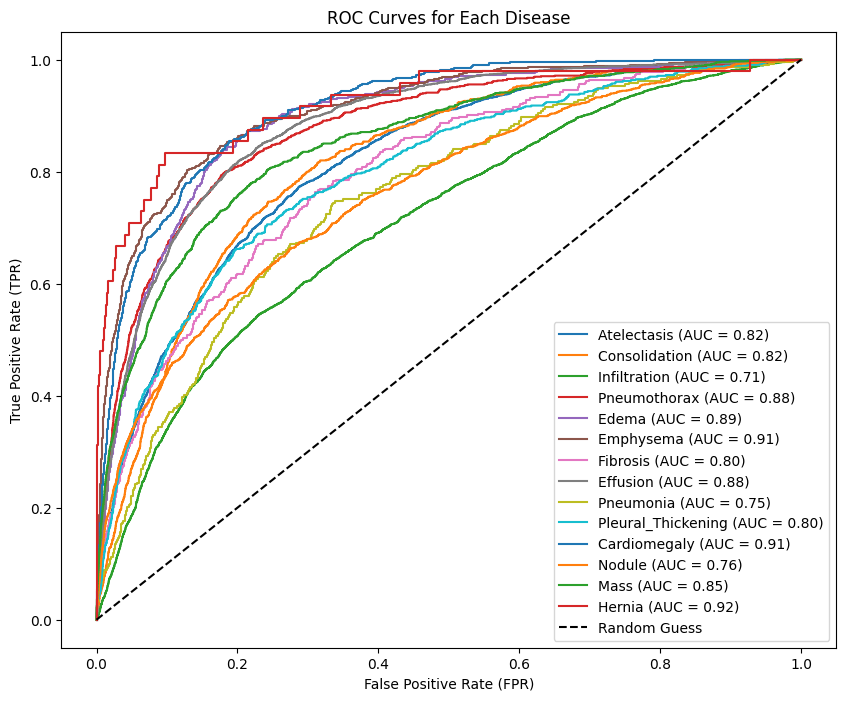

In [ ]:
plt.figure(figsize=(10, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {mean_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='black', label="Random Guess")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for Each Disease')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

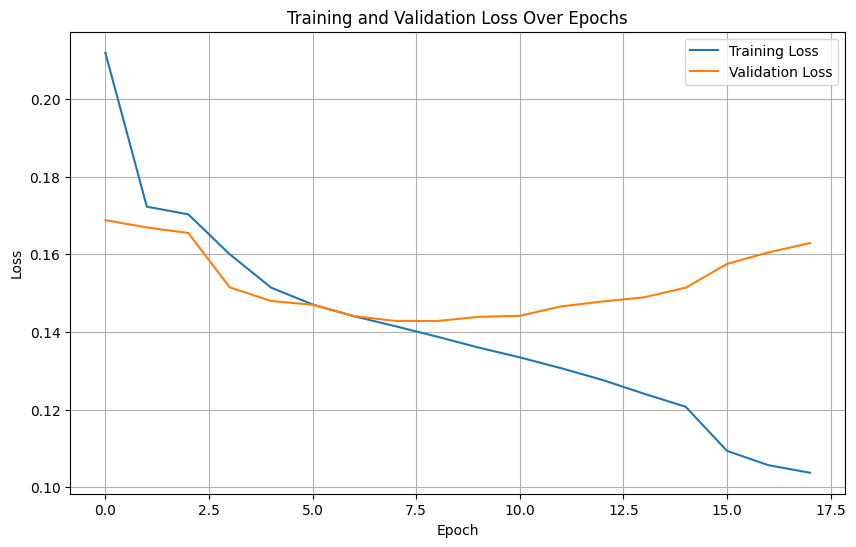

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

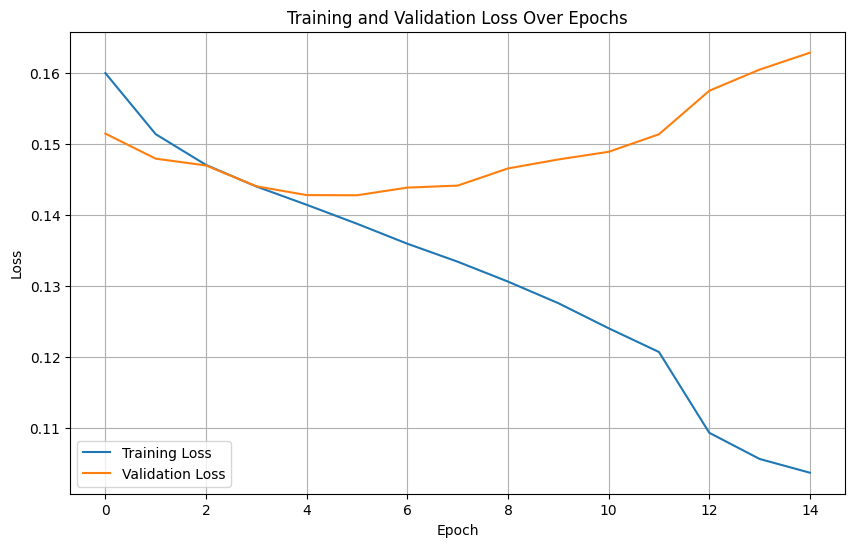

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

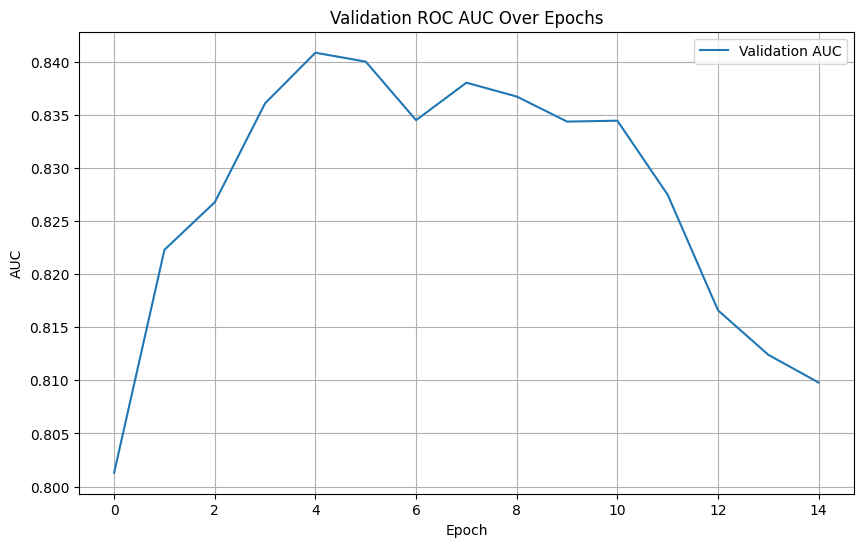

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

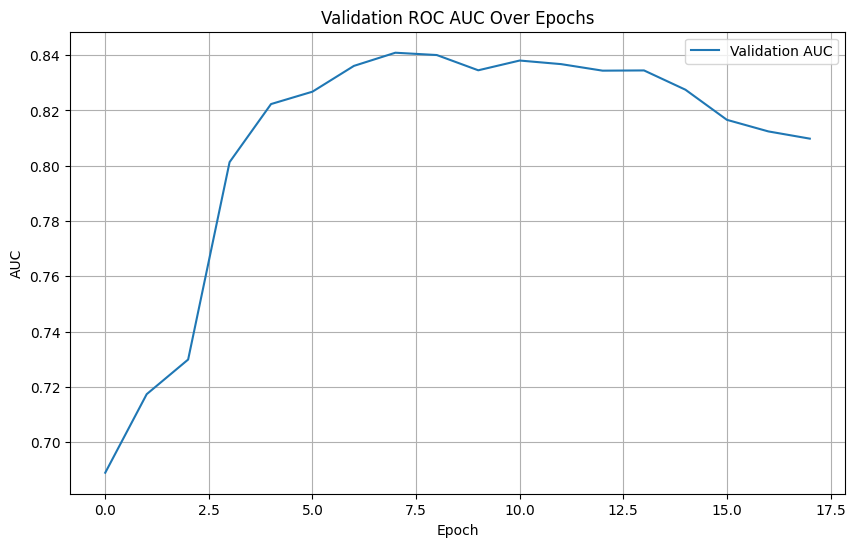

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot MoCo Loss**

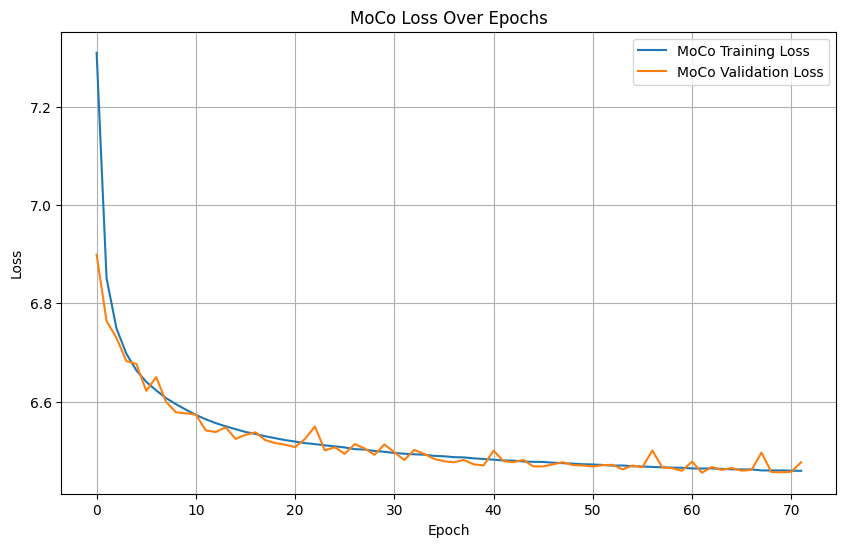

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(moco_train_losses, label='MoCo Training Loss')
plt.plot(moco_val_losses, label='MoCo Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MoCo Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()